**Predicting the probability that a borrower will pay back their loan**

Let's take a first look at the data

In [90]:
import numpy as np
import pandas as pd

train = pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv")
test  = pd.read_csv("/kaggle/input/playground-series-s5e11/test.csv")

In [2]:
train.info()

display(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


Let's take a closer look at the numeric columns of the dataset



In [23]:
train.describe(percentiles=[])

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back
count,593994.0000,593994.0000,593994.0000,593994.0000,593994.0000,593994.0000,593994.0000
mean,296996.5000,48212.2030,0.1207,680.9160,15020.2976,12.3563,0.7988
std,171471.4422,26711.9421,0.0686,55.4250,6926.5306,2.0090,0.4009
min,0.0000,6002.4300,0.0110,395.0000,500.0900,3.2000,0.0000
50%,296996.5000,46557.6800,0.0960,682.0000,15000.2200,12.3700,1.0000
max,593993.0000,393381.7400,0.6270,849.0000,48959.9500,20.9900,1.0000


Let's proceed to examine the non-numeric columns

In [32]:
non_numeric_cols = train.select_dtypes(exclude=['number'])

display(non_numeric_cols)

,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade
0,Female,Single,High School,Self-employed,Other,C3
1,Male,Married,Master's,Employed,Debt consolidation,D3
2,Male,Single,High School,Employed,Debt consolidation,C5
3,Female,Single,High School,Employed,Debt consolidation,F1
4,Male,Married,High School,Employed,Other,D1
...,...,...,...,...,...,...
593989,Female,Single,High School,Employed,Business,C3
593990,Male,Single,Bachelor's,Employed,Debt consolidation,F5
593991,Female,Married,Bachelor's,Employed,Debt consolidation,C1
593992,Male,Single,Bachelor's,Employed,Debt consolidation,B2


Let's check the unique values in each non-numeric column

In [38]:
for col in non_numeric_cols:
    print(f"{col}: {non_numeric_cols[col].unique()}")

gender: ['Female' 'Male' 'Other']
marital_status: ['Single' 'Married' 'Divorced' 'Widowed']
education_level: ['High School' "Master's" "Bachelor's" 'PhD' 'Other']
employment_status: ['Self-employed' 'Employed' 'Unemployed' 'Retired' 'Student']
loan_purpose: ['Other' 'Debt consolidation' 'Home' 'Education' 'Vacation' 'Car'
 'Medical' 'Business']
grade_subgrade: ['C3' 'D3' 'C5' 'F1' 'D1' 'D5' 'C2' 'C1' 'F5' 'D4' 'C4' 'D2' 'E5' 'B1'
 'B2' 'F4' 'A4' 'E1' 'F2' 'B4' 'E4' 'B3' 'E3' 'B5' 'E2' 'F3' 'A5' 'A3'
 'A1' 'A2']


What information would also be very useful:

* borrower's age,
* their tenure at their current/last job,
* presence of legal issues, including those related to paying fines and taxes,
* presence of children and dependents,
* type of housing (owned/rented),
* savings amount,
* presence of open loans,
* loan term,
* macroeconomic factors.

However, instead of dreaming about unavailable information, let's try to make the most of what we have.

Columns credit_score and grade_subgrade are practically measuring the same thing. Let's check how closely they are related

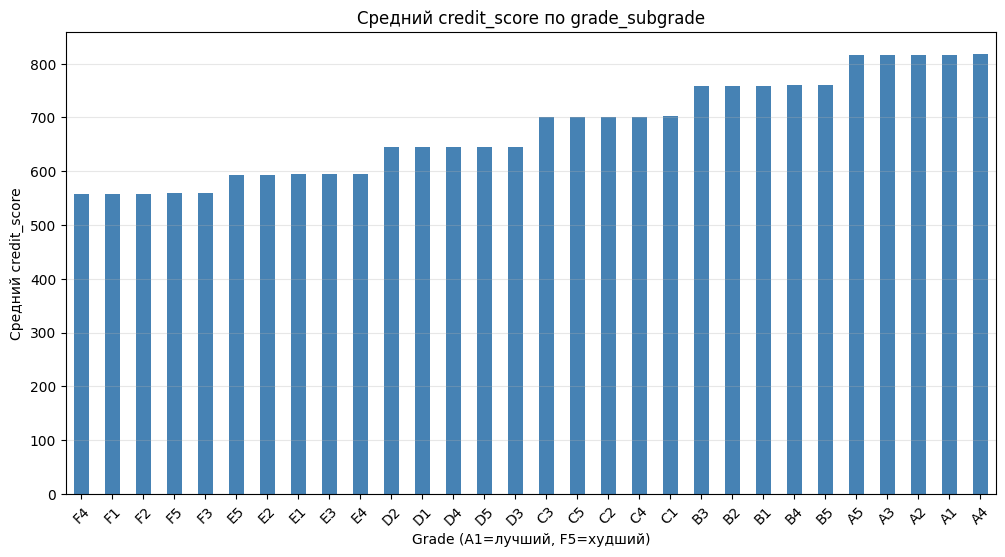

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Средний credit_score по каждому grade_subgrade
mean_scores = train.groupby('grade_subgrade')['credit_score'].mean().sort_values()

# График
plt.figure(figsize=(12, 6))
mean_scores.plot(kind='bar', color='steelblue')
plt.title('Средний credit_score по grade_subgrade')
plt.xlabel('Grade (A1=лучший, F5=худший)')
plt.ylabel('Средний credit_score')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

It might be useful to extract just grade from grade_subgrade as a separate feature

Let's generate additional features

In [91]:
# Simplify grade: extract only the letter (A, B, C, D, E, F)
train['grade'] = train['grade_subgrade'].str[0]

# Create binary risk flag: high-risk grades (D, E, F) = 1
train['is_high_risk'] = train['grade'].isin(['D', 'E', 'F']).astype(int)

# Loan amount relative to annual income
train['loan_to_income'] = train['loan_amount'] / train['annual_income']

# Risk-return indicator: higher ratio indicates higher risk
train['risk_return_ratio'] = train['interest_rate'] / train['credit_score']

# Categorize income into quintiles (5 equal-sized groups)
train['income_quantile'] = pd.qcut(train['annual_income'], q=5, labels=False)


Now let's do encoding

In [92]:
from sklearn.model_selection import KFold

# ONE-HOT ENCODING 
one_hot_cols = ['gender', 'marital_status', 'education_level',
                'employment_status', 'loan_purpose', 'grade']

train = pd.get_dummies(train, columns=one_hot_cols,
                       prefix=one_hot_cols, drop_first=True)

# MEAN TARGET ENCODING 
def mean_target_encoding_cv(df, col, target, n_folds=5, random_state=42):
    
    # With cross-validation to prevent data leakage
    # Create an array for results
    encoded = np.zeros(len(df))

    # Let's split into folds
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

    for train_idx, val_idx in kf.split(df):
        # Calculating means from the training fold
        means = df.iloc[train_idx].groupby(col)[target].mean()
        # Using to the validation fold
        encoded[val_idx] = df.iloc[val_idx][col].map(means)

    # No missing values - no step needed

    return pd.Series(encoded, index=df.index, name=f'{col}_encoded')

# Finally encoding grade_subgrade
train['grade_subgrade_encoded'] = mean_target_encoding_cv(
    train,
    'grade_subgrade',
    'loan_paid_back',
    n_folds=5
)

# ===========

# Saving some details for processing **test** dataset later
# Save quintile boundaries from training data
_, train_income_bins = pd.qcut(train['annual_income'], q=5, retbins=True)

# Calculate mean target encoding values from training data
grade_subgrade_means = train.groupby('grade_subgrade')['loan_paid_back'].mean()

# Calculate overall mean for handling unseen categories
overall_mean = train['loan_paid_back'].mean()

# ===========


# Dropping original columns EXCEPT OF grade_subgrade which is still needed (see lower)
train.drop(columns=one_hot_cols, inplace=True, errors='ignore')
print(f"\nFinal number of columns after dropping originals: {train.shape[1]}")


Final number of columns after dropping originals: 38


Now, let's apply the same transformations to the **test** dataset to prepare it for prediction.

In [93]:
# Simplify grade: extract only the letter (A, B, C, D, E, F)
test['grade'] = test['grade_subgrade'].str[0]

# Create binary risk flag: high-risk grades (D, E, F) = 1
test['is_high_risk'] = test['grade'].isin(['D', 'E', 'F']).astype(int)

# Loan amount relative to annual income
test['loan_to_income'] = test['loan_amount'] / test['annual_income']

# Risk-return indicator: higher ratio indicates higher risk
test['risk_return_ratio'] = test['interest_rate'] / test['credit_score']

# Apply quintile boundaries from TRAIN data
test['income_quantile'] = pd.cut(
    test['annual_income'], 
    bins=train_income_bins,  # Исправлено: train_income_bins вместо train_income_quantiles
    labels=False,
    include_lowest=True
)

# ONE-HOT ENCODING for test data
# Используем те же колонки
test_one_hot_cols = ['gender', 'marital_status', 'education_level',
                     'employment_status', 'loan_purpose', 'grade']

# Для one-hot encoding нужно убедиться, что все категории совпадают с train
test = pd.get_dummies(test, columns=test_one_hot_cols,
                      prefix=test_one_hot_cols, drop_first=True)

# Mean Target Encoding based on means from TRAIN
test['grade_subgrade_encoded'] = test['grade_subgrade'].map(grade_subgrade_means)
test['grade_subgrade_encoded'] = test['grade_subgrade_encoded'].fillna(overall_mean)

# Dropping original columns from test
test.drop(columns=test_one_hot_cols + ['grade_subgrade'], inplace=True, errors='ignore')

# Ensure test has the same columns as train

# Verify that train and test have identical feature columns
# Excluding grade_subgrade and the target variable loan_paid_back from train
train_cols_without_two = [col for col in train.columns if col not in ['grade_subgrade', 'loan_paid_back']]
columns_match = set(train_cols_without_two) == set(test.columns)

print(f"\nTrain and test have identical feature sets: {columns_match}")
print(f"\nFinal number of columns in test: {test.shape[1]}")


Train and test have identical feature sets: True

Final number of columns in test: 36


Now grade_subgrade column is no longer needed

In [94]:
train.drop(columns=['grade_subgrade'], inplace=True, errors='ignore')

Separating features (X) and target (y) from **train**

In [95]:
X = train.drop('loan_paid_back', axis=1)  # All columns except target
y = train['loan_paid_back']

A few words about the test dataframe

The test dataframe differs from train only in the absence of the target variable loan_paid_back
The target variable takes the values 1 or 0, as expected
test dataframe has fewer observations, specifically 254,569

Verify that **test** and **X** have exactly the same features

In [96]:
# Ensure feature sets are identical
assert set(test.columns) == set(X.columns), "Feature sets do not match!"

# Reorder test columns to match X
test = test[X.columns]

print(f"Columns properly ordered: {all(test.columns == X.columns)}")

Columns properly ordered: True


Splitting data into train/validation sets (80/20), calculating the class imbalance ratio (positive/negative) for boosting

In [52]:
from sklearn.model_selection import train_test_split 

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

neg, pos = (y_train == 0).sum(), (y_train == 1).sum()
scale = pos / neg  

print(f"Train class balance - 0: {neg:,} | 1: {pos:,} | scale: {scale:.3f}")

Train class balance - 0: 95,600 | 1: 379,595 | scale: 3.971


Now, let's apply the same transformations to the **test** dataset to prepare it for prediction.

Optimizing LightGBM parameters using Optuna

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

#  CALcULATING SCALE 
scale = (y_train == 1).sum() / (y_train == 0).sum()
print(f"Class imbalance - positive/negative ratio: {scale:.3f}")

#  OPTUNA 
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 7, 127),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'scale_pos_weight': scale,  
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': -1
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
    )
    
    val_pred = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, val_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

In [31]:
for key, value in study.best_params.items():
    print(f"{key}: {value}")

n_estimators: 898
learning_rate: 0.21332566495108582
max_depth: 4
num_leaves: 61
subsample: 0.5996797133828635
colsample_bytree: 0.9587827368012877
min_child_samples: 63
reg_lambda: 8.734857454898087
reg_alpha: 2.3369549755653574


In [97]:
best_params_lgb = {
    "n_estimators": 898,
    "learning_rate": 0.21332566495108582,
    "max_depth": 4,
    "num_leaves": 61,
    "subsample": 0.5996797133828635,
    "colsample_bytree": 0.9587827368012877,
    "min_child_samples": 63,
    "reg_lambda": 8.734857454898087,
    "reg_alpha": 2.3369549755653574,
    "scale_pos_weight": scale,
    "random_state": 42,
    "n_jobs": -1,
    "verbosity": -1
}

Training with best parameters

In [98]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')

lgb_best = lgb.LGBMClassifier(**best_params_lgb)
lgb_best.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=True)]
)

# Model evaluation
lgb_val_proba = lgb_best.predict_proba(X_val)[:, 1]
lgb_val_pred = (lgb_val_proba >= 0.5).astype(int)

from sklearn.metrics import roc_auc_score, accuracy_score

roc_auc = roc_auc_score(y_val, lgb_val_proba)
accuracy = accuracy_score(y_val, lgb_val_pred)

print(f"\n Model Performance:")
print(f"ROC AUC: {roc_auc:.5f}")
print(f"Accuracy: {accuracy:.5f}")

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[538]	valid_0's auc: 0.922506	valid_0's binary_logloss: 0.296806

 Model Performance:
ROC AUC: 0.92251
Accuracy: 0.89837


Now CatBoost

In [ ]:
import optuna
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from catboost import CatBoostClassifier

def objective_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 5000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'depth': trial.suggest_int('depth', 3, 12),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10.0, log=True), 
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10.0, log=True), 
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_seed': 42,
        'verbose': False,
        'auto_class_weights': 'Balanced'
    }
    
    model = CatBoostClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=(X_val, y_val),
        early_stopping_rounds=100,
        verbose=False
    )
    
    val_pred = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, val_pred)

study_catboost = optuna.create_study(direction='maximize')
study_catboost.optimize(objective_catboost, n_trials=30, show_progress_bar=True)

In [17]:
for key, value in study_catboost.best_params.items():
    print(f"{key}: {value}")

iterations: 4473
learning_rate: 0.15453379360741887
depth: 3
l2_leaf_reg: 0.20108179976146479
border_count: 255
random_strength: 0.5023840800337046
bagging_temperature: 0.532356721162755


In [100]:
best_params_catboost = {
    "iterations": 4473,
    "learning_rate": 0.15453379360741887,
    "depth": 3,
    "l2_leaf_reg": 0.20108179976146479,
    "border_count": 255,
    "random_strength": 0.5023840800337046,
    "bagging_temperature": 0.532356721162755,
    "random_seed": 42,
    "verbose": False,
    "auto_class_weights": "Balanced"
}

In [101]:
from sklearn.metrics import accuracy_score, roc_auc_score
from catboost import CatBoostClassifier
from catboost import CatBoostClassifier

catboost_best = CatBoostClassifier(**best_params_catboost)
catboost_best.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=200,
    verbose=0
)

catboost_val_proba = catboost_best.predict_proba(X_val)[:, 1]
catboost_val_pred = (catboost_val_proba >= 0.5).astype(int)

roc_auc_catboost = roc_auc_score(y_val, catboost_val_proba)
accuracy_catboost = accuracy_score(y_val, catboost_val_pred)

print(f"\nCatBoost Performance:")
print(f"ROC AUC: {roc_auc_catboost:.5f}")
print(f"Accuracy: {accuracy_catboost:.5f}")


CatBoost Performance:
ROC AUC: 0.92311
Accuracy: 0.87050


In [ ]:
Now XGBoost

In [ ]:
import xgboost as xgb

def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'scale_pos_weight': scale,
        'random_state': 42,
        'n_jobs': -1,
        'eval_metric': 'auc'
    }
    
    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=100,
        verbose=False
    )
    
    val_pred = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, val_pred)

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=30, show_progress_bar=True)

In [35]:
for key, value in study_xgb.best_params.items():
    print(f"{key}: {value}")

n_estimators: 1875
learning_rate: 0.2269169868449671
max_depth: 3
subsample: 0.9931656154291065
colsample_bytree: 0.6446836139058001
min_child_weight: 16
reg_lambda: 8.734622977317336
reg_alpha: 0.008463166778502106


In [102]:
best_params_xgb = {
    "n_estimators": 1875,
    "learning_rate": 0.2269169868449671,
    "max_depth": 3,
    "subsample": 0.9931656154291065,
    "colsample_bytree": 0.6446836139058001,
    "min_child_weight": 16,
    "reg_lambda": 8.734622977317336,
    "reg_alpha": 0.008463166778502106,
    "scale_pos_weight": scale,
    "random_state": 42,
    "n_jobs": -1,
    "eval_metric": "auc"
}

In [103]:
import xgboost as xgb

xgb_best = xgb.XGBClassifier(**best_params_xgb)
xgb_best.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=200,
    verbose=0
)

xgb_val_proba = xgb_best.predict_proba(X_val)[:, 1]
xgb_val_pred = (xgb_val_proba >= 0.5).astype(int)

roc_auc_xgb = roc_auc_score(y_val, xgb_val_proba)
accuracy_xgb = accuracy_score(y_val, xgb_val_pred)

print(f"\n XGBoost Performance:")
print(f"ROC AUC: {roc_auc_xgb:.5f}")
print(f"Accuracy: {accuracy_xgb:.5f}")


 XGBoost Performance:
ROC AUC: 0.92105
Accuracy: 0.89796


Ensemble Weight Optimization for XGBoost + CatBoost + LightGBM

In [82]:
print("\n" + "="*50)
print("ENSEMBLE WEIGHT OPTIMIZATION")
print("="*50)

# Display individual model performance on validation set
print("\nIndividual Model Performance (Validation Set):")
print(f"XGBoost  ROC-AUC: {roc_auc_xgb:.5f}")
print(f"CatBoost ROC-AUC: {roc_auc_catboost:.5f}")
print(f"LightGBM ROC-AUC: {roc_auc:.5f}")

# Initialize variables for best ensemble
best_auc = 0
best_weights = (1.0, 0.0, 0.0)  # default: only first model
best_val_proba = None

# Define weight search range (0 to 1 with 0.05 step)
weights_range = np.arange(0.0, 1.01, 0.05)

# Iterate through all possible weight combinations
print("\nSearching for optimal weights...")
print("Weights range: 0.0 to 1.0 with step 0.05")

for w_xgb in weights_range:
    for w_cat in weights_range:
        w_lgb = 1.0 - (w_xgb + w_cat)
        
        # Skip invalid weight combinations (negative weight)
        if w_lgb < 0:
            continue
        
        # Create weighted ensemble prediction
        ensemble_val_proba = (
            w_xgb * xgb_val_proba +
            w_cat * catboost_val_proba +
            w_lgb * lgb_val_proba
        )
        
        # Calculate ensemble ROC-AUC
        auc = roc_auc_score(y_val, ensemble_val_proba)
        
        # Update best weights if current combination is better
        if auc > best_auc:
            best_auc = auc
            best_weights = (w_xgb, w_cat, w_lgb)
            best_val_proba = ensemble_val_proba

# Display results
print("\n" + "="*50)
print("OPTIMAL ENSEMBLE FOUND")
print("="*50)
print(f"Best Ensemble ROC-AUC: {best_auc:.5f}")
print(f"Improvement over best single model: {best_auc - max(roc_auc_xgb, roc_auc_catboost, roc_auc):.5f}")
print(f"\nOptimal Weights:")
print(f"  XGBoost:  {best_weights[0]:.2f}")
print(f"  CatBoost: {best_weights[1]:.2f}")
print(f"  LightGBM: {best_weights[2]:.2f}")

# Calculate ensemble accuracy with optimal weights
ensemble_val_pred = (best_val_proba >= 0.5).astype(int)
ensemble_accuracy = accuracy_score(y_val, ensemble_val_pred)

print(f"\nEnsemble Validation Accuracy: {ensemble_accuracy:.5f}")


ENSEMBLE WEIGHT OPTIMIZATION

Individual Model Performance (Validation Set):
XGBoost  ROC-AUC: 0.92105
CatBoost ROC-AUC: 0.92311
LightGBM ROC-AUC: 0.92251

Searching for optimal weights...
Weights range: 0.0 to 1.0 with step 0.05

OPTIMAL ENSEMBLE FOUND
Best Ensemble ROC-AUC: 0.92333
Improvement over best single model: 0.00022

Optimal Weights:
  XGBoost:  0.00
  CatBoost: 0.30
  LightGBM: 0.70

Ensemble Validation Accuracy: 0.90309


In [76]:
print("Making predictions on test data...")

xgb_pred = xgb_best.predict_proba(test)[:, 1]
cat_pred = catboost_best.predict_proba(test)[:, 1]
lgb_pred = lgb_best.predict_proba(test)[:, 1]

# Using optimal weights
ensemble_proba = (
    best_weights[0] * xgb_pred +
    best_weights[1] * cat_pred +
    best_weights[2] * lgb_pred
)

# Convert probabilities to binary predictions
binary_predictions = (ensemble_proba >= 0.5).astype(int)

Making predictions on test data...


In [77]:
submission = pd.DataFrame({
    "id": test["id"] if "id" in test.columns else test.index,
    "loan_paid_back": binary_predictions  # Бинарные предсказания
})

submission.to_csv("final_submission.csv", index=False)